In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings

from collections import Counter
from matplotlib import ticker
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.QED import properties
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

### Load the data

In [2]:
## hERG
data_herg_dev = pd.read_csv("../data/raw/hERG/data_herg_dev.csv")
data_herg_dev['USED_AS'] = 'Dev-Set'
eval_herg_set_60 = pd.read_csv("../data/raw/hERG/eval_set_herg_60.csv")
eval_herg_set_60['USED_AS'] = 'Eval-Set-60'
eval_herg_set_70 = pd.read_csv("../data/raw/hERG/eval_set_herg_70.csv")
eval_herg_set_70['USED_AS'] = 'Eval-Set-70'
## Nav1.5
data_nav_dev = pd.read_csv("../data/raw/Nav1.5/data_nav_dev.csv")
data_nav_dev['USED_AS'] = 'Dev-Set'
eval_nav_set_60 = pd.read_csv("../data/raw/Nav1.5/eval_set_nav_60.csv")
eval_nav_set_60['USED_AS'] = 'Eval-Set-60'
eval_nav_set_70 = pd.read_csv("../data/raw/Nav1.5/eval_set_nav_70.csv")
eval_nav_set_70['USED_AS'] = 'Eval-Set-70'
## Cav1.2
data_cav_dev = pd.read_csv("../data/raw/Cav1.2/data_cav_dev.csv")
data_cav_dev['USED_AS'] = 'Dev-Set'
eval_cav_set_60 = pd.read_csv("../data/raw/Cav1.2/eval_set_cav_60.csv")
eval_cav_set_60['USED_AS'] = 'Eval-Set-60'
eval_cav_set_70 = pd.read_csv("../data/raw/Cav1.2/eval_set_cav_70.csv")
eval_cav_set_70['USED_AS'] = 'Eval-Set-70'

## Group All dataset categories
datasets_dev=[data_herg_dev,data_nav_dev,data_cav_dev]
datasets_60=[eval_herg_set_60,eval_nav_set_60,eval_cav_set_60]
datasets_70=[eval_herg_set_70,eval_nav_set_70,eval_cav_set_70]
#Concatinate all to check intersection

data_herg = pd.concat([data_herg_dev,eval_herg_set_60,eval_herg_set_70])
data_nav = pd.concat([data_nav_dev,eval_nav_set_60,eval_nav_set_70])
data_cav = pd.concat([data_cav_dev,eval_cav_set_60,eval_cav_set_70])

In [3]:
## hERG
with open('../data/precomputed_features/hERG/_herg_dev_fingerprints.pkl', 'rb') as f:
    _herg_dev_fingerprints = pickle.load(f)
with open('../data/precomputed_features/hERG/_herg_set70_fingerprints.pkl', 'rb') as f:
    _herg_set70_fingerprints = pickle.load(f)
with open('../data/precomputed_features/hERG/_herg_set60_fingerprints.pkl', 'rb') as f:
    _herg_set60_fingerprints = pickle.load(f)
with open('../data/precomputed_features/hERG/_herg_dev_descriptors.pkl', 'rb') as f:
    _herg_dev_descriptors = pickle.load(f)
with open('../data/precomputed_features/hERG/_herg_set70_descriptors.pkl', 'rb') as f:
    _herg_set70_descriptors = pickle.load(f)
with open('../data/precomputed_features/hERG/_herg_set60_descriptors.pkl', 'rb') as f:
    _herg_set60_descriptors = pickle.load(f)

## Nav1.5
with open('../data/precomputed_features/Nav1.5/_nav_dev_fingerprints.pkl', 'rb') as f:
    _nav_dev_fingerprints = pickle.load(f)
with open('../data/precomputed_features/Nav1.5/_nav_set70_fingerprints.pkl', 'rb') as f:
    _nav_set70_fingerprints = pickle.load(f)
with open('../data/precomputed_features/Nav1.5/_nav_set60_fingerprints.pkl', 'rb') as f:
    _nav_set60_fingerprints = pickle.load(f)
with open('../data/precomputed_features/Nav1.5/_nav_dev_descriptors.pkl', 'rb') as f:
    _nav_dev_descriptors = pickle.load(f)
with open('../data/precomputed_features/Nav1.5/_nav_set70_descriptors.pkl', 'rb') as f:
    _nav_set70_descriptors = pickle.load(f)
with open('../data/precomputed_features/Nav1.5/_nav_set60_descriptors.pkl', 'rb') as f:
    _nav_set60_descriptors = pickle.load(f)
    
## Cav1.2
with open('../data/precomputed_features/Cav1.2/_cav_dev_fingerprints.pkl', 'rb') as f:
    _cav_dev_fingerprints = pickle.load(f)
with open('../data/precomputed_features/Cav1.2/_cav_set70_fingerprints.pkl', 'rb') as f:
    _cav_set70_fingerprints = pickle.load(f)
with open('../data/precomputed_features/Cav1.2/_cav_set60_fingerprints.pkl', 'rb') as f:
    _cav_set60_fingerprints = pickle.load(f)
with open('../data/precomputed_features/Cav1.2/_cav_dev_descriptors.pkl', 'rb') as f:
    _cav_dev_descriptors = pickle.load(f)
with open('../data/precomputed_features/Cav1.2/_cav_set70_descriptors.pkl', 'rb') as f:
    _cav_set70_descriptors = pickle.load(f)
with open('../data/precomputed_features/Cav1.2/_cav_set60_descriptors.pkl', 'rb') as f:
    _cav_set60_descriptors = pickle.load(f)

#Concatinate all to check intersection
data_herg_fingerprints = np.concatenate((_herg_dev_fingerprints,_herg_set70_fingerprints,_herg_set60_fingerprints), axis=0)
data_nav_fingerprints = np.concatenate((_nav_dev_fingerprints,_nav_set60_fingerprints,_nav_set70_fingerprints), axis=0)
data_cav_fingerprints = np.concatenate((_cav_dev_fingerprints,_cav_set60_fingerprints,_cav_set70_fingerprints), axis=0)

### Tanimoto similarity between sets

In [4]:
## Generate fingerprints for hERG
data_herg["mol_object"] = data_herg.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
data_herg["Fingerprint"] = data_herg.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
## Generate fingerprints for Cav1.2
data_cav["mol_object"] = data_cav.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
data_cav["Fingerprint"] = data_cav.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
## Generate fingerprints for Nav1.5
data_nav["mol_object"] = data_nav.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
data_nav["Fingerprint"] = data_nav.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)

In [5]:
## Compute TanimotoSimilarity for hERG
herg_eval_70_TanimotoSimilarity_dev = []
for idx, fp1 in enumerate(data_herg[data_herg["USED_AS"] == 'Eval-Set-70']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_herg[data_herg["USED_AS"] == 'Dev-Set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_eval_70_TanimotoSimilarity_dev.append(Tsim)
herg_eval_60_TanimotoSimilarity_dev = []
for idx, fp1 in enumerate(data_herg[data_herg["USED_AS"] == 'Eval-Set-60']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_herg[data_herg["USED_AS"] == 'Dev-Set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_eval_60_TanimotoSimilarity_dev.append(Tsim)
herg_eval_60_TanimotoSimilarity_eval_70 = []
for idx, fp1 in enumerate(data_herg[data_herg["USED_AS"] == 'Eval-Set-60']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_herg[data_herg["USED_AS"] == 'Eval-Set-70']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_eval_60_TanimotoSimilarity_eval_70.append(Tsim)

## Compute TanimotoSimilarity for Nav1.5
nav_eval_70_TanimotoSimilarity_dev = []
for idx, fp1 in enumerate(data_nav[data_nav["USED_AS"] == 'Eval-Set-70']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_nav[data_nav["USED_AS"] == 'Dev-Set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_eval_70_TanimotoSimilarity_dev.append(Tsim)
nav_eval_60_TanimotoSimilarity_dev = []
for idx, fp1 in enumerate(data_nav[data_nav["USED_AS"] == 'Eval-Set-60']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_nav[data_nav["USED_AS"] == 'Dev-Set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_eval_60_TanimotoSimilarity_dev.append(Tsim)
nav_eval_60_TanimotoSimilarity_eval_70 = []
for idx, fp1 in enumerate(data_nav[data_nav["USED_AS"] == 'Eval-Set-60']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_nav[data_nav["USED_AS"] == 'Eval-Set-70']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_eval_60_TanimotoSimilarity_eval_70.append(Tsim)
        
## Compute TanimotoSimilarity for Cav1.2
cav_eval_70_TanimotoSimilarity_dev = []
for idx, fp1 in enumerate(data_cav[data_cav["USED_AS"] == 'Eval-Set-70']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_cav[data_cav["USED_AS"] == 'Dev-Set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        cav_eval_70_TanimotoSimilarity_dev.append(Tsim)
cav_eval_60_TanimotoSimilarity_dev = []
for idx, fp1 in enumerate(data_cav[data_cav["USED_AS"] == 'Eval-Set-60']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_cav[data_cav["USED_AS"] == 'Dev-Set']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        cav_eval_60_TanimotoSimilarity_dev.append(Tsim)
cav_eval_60_TanimotoSimilarity_eval_70 = []
for idx, fp1 in enumerate(data_cav[data_cav["USED_AS"] == 'Eval-Set-60']["Fingerprint"],0):
    for idx2,fp2 in enumerate(list(data_cav[data_cav["USED_AS"] == 'Eval-Set-70']["Fingerprint"])):
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        cav_eval_60_TanimotoSimilarity_eval_70.append(Tsim)

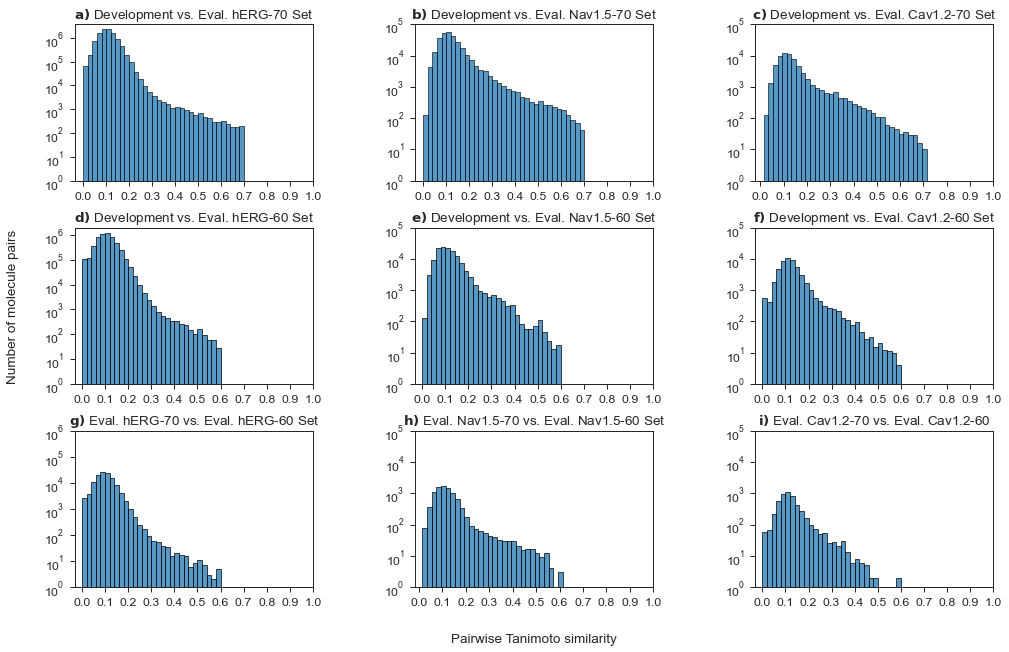

In [6]:
## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 14
height = width / 1.618
fig,  axes = plt.subplots(3,3,figsize=(width, height))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

g1 = sns.histplot(herg_eval_70_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax1)
g2 = sns.histplot(nav_eval_70_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax2)
g3 = sns.histplot(cav_eval_70_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax3)
g4 = sns.histplot(herg_eval_60_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax4)
g5 = sns.histplot(nav_eval_60_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax5)
g6 = sns.histplot(cav_eval_60_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax6)
g7 = sns.histplot(herg_eval_60_TanimotoSimilarity_eval_70,fill=True, binwidth=0.02, ax=ax7)
g8 = sns.histplot(nav_eval_60_TanimotoSimilarity_eval_70,fill=True, binwidth=0.02, ax=ax8)
g9 = sns.histplot(cav_eval_60_TanimotoSimilarity_eval_70,fill=True, binwidth=0.02, ax=ax9)
fig.tight_layout()
ax1.title.set_text('$\\mathbf{a)}$ Development vs. Eval. hERG-70 Set')
ax1.set_ylabel('')
g1.set(yscale="log")
ax2.set_ylabel('')
ax2.title.set_text('$\\mathbf{b)}$ Development vs. Eval. Nav1.5-70 Set')
g2.set(yscale="log")
ax3.title.set_text('$\\mathbf{c)}$ Development vs. Eval. Cav1.2-70 Set')
ax3.set_ylabel('')
g3.set(yscale="log")
ax4.title.set_text('$\\mathbf{d)}$ Development vs. Eval. hERG-60 Set')
ax4.set_ylabel('Number of molecule pairs', labelpad=25)
g4.set(yscale="log")
ax5.title.set_text('$\\mathbf{e)}$ Development vs. Eval. Nav1.5-60 Set')
ax5.set_ylabel('')
g5.set(yscale="log")
ax6.set_ylabel('')
ax6.title.set_text('$\\mathbf{f)}$ Development vs. Eval. Cav1.2-60 Set')
g6.set(yscale="log")
ax7.title.set_text('$\\mathbf{g)}$ Eval. hERG-70 vs. Eval. hERG-60 Set')
ax7.set_ylabel('')
g7.set(yscale="log")
ax8.set_xlabel('Pairwise Tanimoto similarity', labelpad=25)
ax8.title.set_text('$\\mathbf{h)}$ Eval. Nav1.5-70 vs. Eval. Nav1.5-60 Set')
ax8.set_ylabel('')
g8.set(yscale="log")
ax9.title.set_text('$\\mathbf{i)}$ Eval. Cav1.2-70 vs. Eval. Cav1.2-60')
ax9.set_ylabel('')
g9.set(yscale="log")
plt.setp([ax1,ax4,ax7], 
         xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
         yticks=[1, 10, 100, 1000, 10000, 100000, 1000000])
plt.setp([ax2,ax3,ax5,ax6,ax8,ax9], 
         xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
         yticks=[1, 10, 100, 1000, 10000, 100000])
# Add space between subplots
plt.subplots_adjust(wspace=0.43, hspace=0.3)
# Plot
plt.show()

### pIC50 distribution

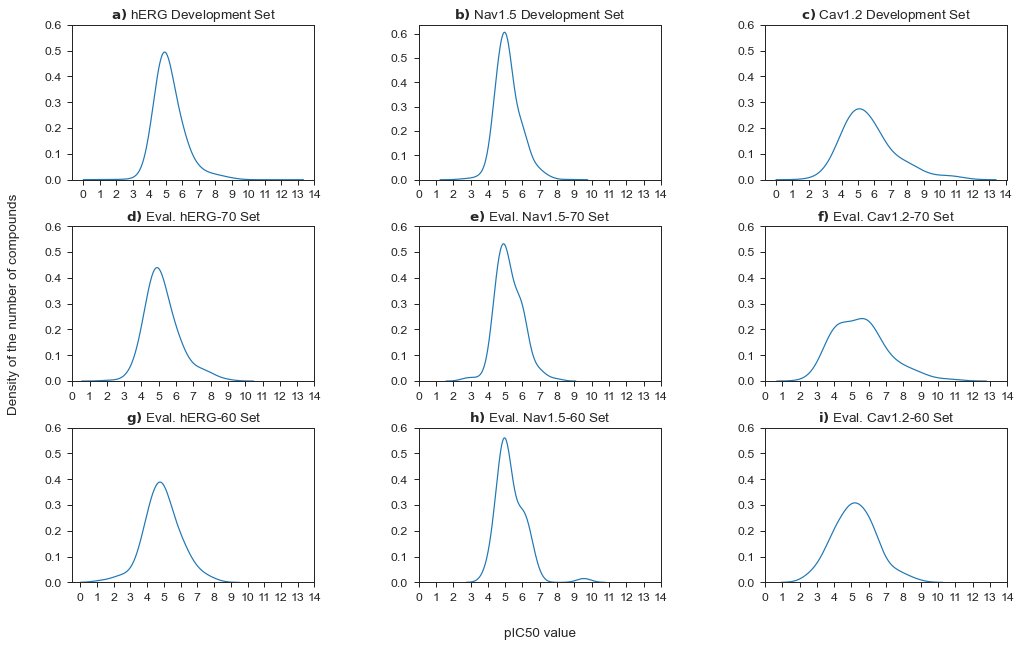

In [7]:
## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 14
height = width / 1.618
fig,  axes = plt.subplots(3,3,figsize=(width, height))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

g1 = sns.kdeplot(data_herg[data_herg["USED_AS"] == 'Dev-Set']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax1)
g2 = sns.kdeplot(data_nav[data_nav["USED_AS"] == 'Dev-Set']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax2)
g3 = sns.kdeplot(data_cav[data_cav["USED_AS"] == 'Dev-Set']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax3)
g4 = sns.kdeplot(data_herg[data_herg["USED_AS"] == 'Eval-Set-70']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax4)
g5 = sns.kdeplot(data_nav[data_nav["USED_AS"] == 'Eval-Set-70']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax5)
g6 = sns.kdeplot(data_cav[data_cav["USED_AS"] == 'Eval-Set-70']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax6)
g7 = sns.kdeplot(data_herg[data_herg["USED_AS"] == 'Eval-Set-60']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax7)
g8 = sns.kdeplot(data_nav[data_nav["USED_AS"] == 'Eval-Set-60']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax8)
g9 = sns.kdeplot(data_cav[data_cav["USED_AS"] == 'Eval-Set-60']["pIC50"], bw_method=0.5, clip=(0, 14), ax=ax9)
fig.tight_layout()
ax1.title.set_text('$\\mathbf{a)}$ hERG Development Set')
ax1.set(ylabel='',xlabel='' )
ax2.set(ylabel='',xlabel='')
ax2.title.set_text('$\\mathbf{b)}$ Nav1.5 Development Set')
ax3.title.set_text('$\\mathbf{c)}$ Cav1.2 Development Set')
ax3.set(ylabel='',xlabel='')
ax4.title.set_text('$\\mathbf{d)}$ Eval. hERG-70 Set')
ax4.set_ylabel('Density of the number of compounds', labelpad=25)
ax4.set_xlabel('')
ax5.title.set_text('$\\mathbf{e)}$ Eval. Nav1.5-70 Set')
ax5.set(ylabel='',xlabel='')
ax6.set(ylabel='',xlabel='')
ax6.title.set_text('$\\mathbf{f)}$ Eval. Cav1.2-70 Set')
ax7.title.set_text('$\\mathbf{g)}$ Eval. hERG-60 Set')
ax7.set(ylabel='',xlabel='')
ax8.set_xlabel('pIC50 value', labelpad=25)
ax8.title.set_text('$\\mathbf{h)}$ Eval. Nav1.5-60 Set')
ax8.set_ylabel('')
ax9.title.set_text('$\\mathbf{i)}$ Eval. Cav1.2-60 Set')
ax9.set(ylabel='',xlabel='')
plt.xlim(0, 14)
plt.setp([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9], 
         xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
         yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Add space between subplots
plt.subplots_adjust(wspace=0.43, hspace=0.3)
# Plot
plt.show()

### Share of upstream datasources

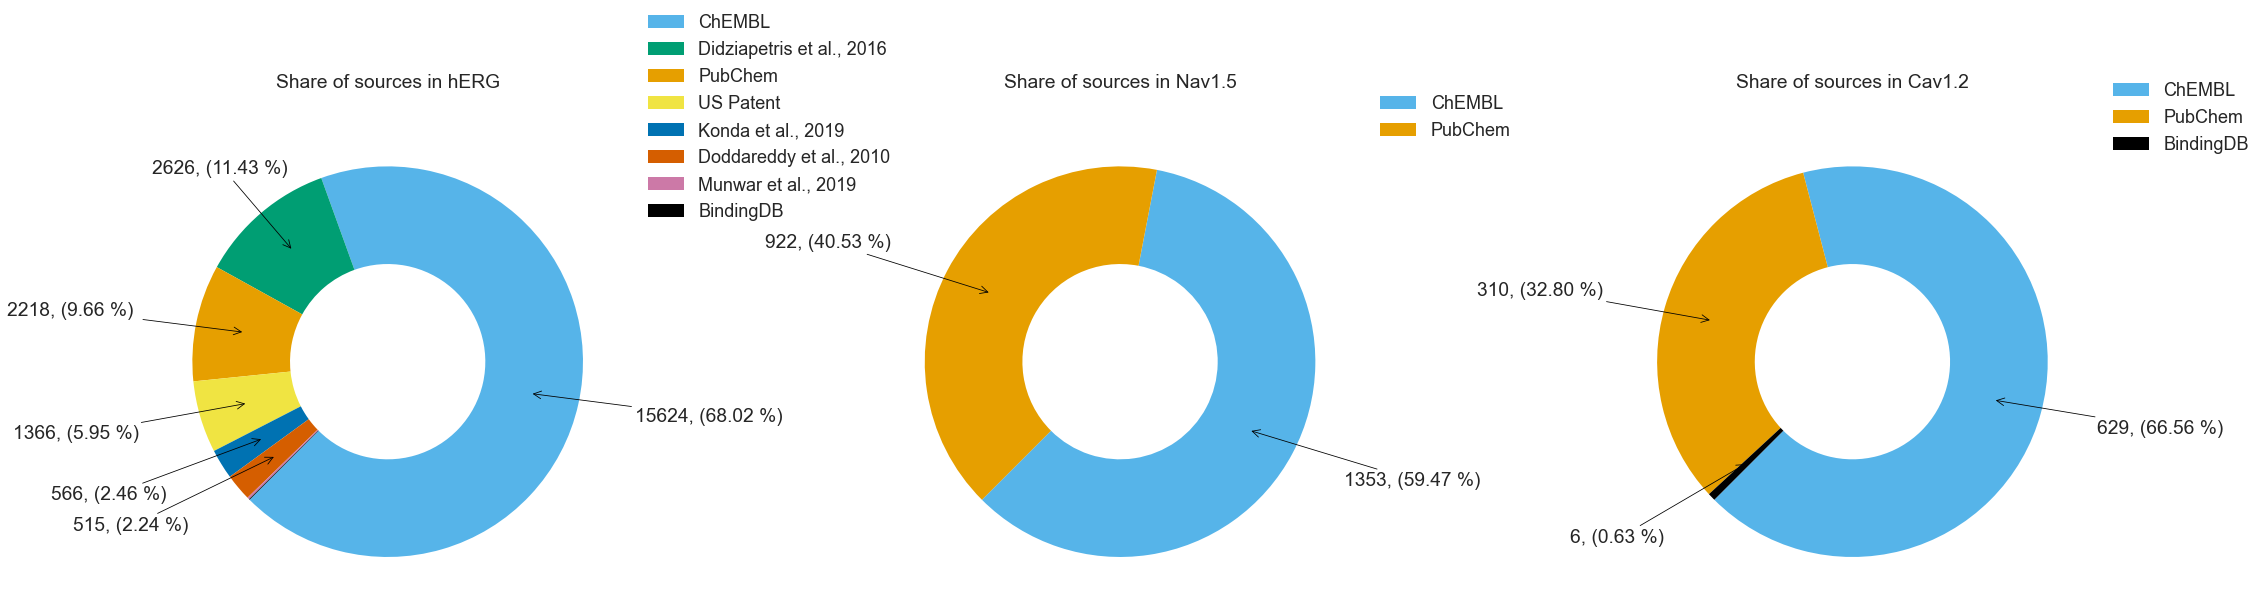

In [8]:

## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=2.0)    # Single-column figure.
width = 35
height = width / 1.618
fig,aks = plt.subplots(1,3,figsize=(width, height))

#Generating Sources pie chart
#fig,aks = plt.subplots(3,3,figsize=(30, 20))
targets =["hERG","Nav1.5","Cav1.2"]
sets=["-Dev","-70","-60"]
colors={}
list_of_colors=["#56B4E9", "#009E73", "#E69F00", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

def plot_source_pie(data,aks,title):
    frequency = Counter(list(data.Source))
    labels = []
    sizes = []
    annotations=[]
    color_for_pie=[]
    for x, y in frequency.most_common():
        #print(x)
        sizes.append(y)
        labels.append("{}".format(x))
        if x not in colors:
            colors[x]=list_of_colors.pop(0)
        color_for_pie.append(colors[x])
        
    for size in sizes:
        annotations.append("{}, ({:.2f} %) ".format(size, 100*size/sum(sizes)))
    # Plot
    wedges,teksts=aks.pie(sizes,colors=color_for_pie,wedgeprops=dict(width=0.5), startangle=225)
    kw = dict(arrowprops=dict(arrowstyle="->"), va="center")
    
    #generate wedges, if its less than 0.2 percent, dont show the annotation
    for p, label in zip(wedges, annotations):
        amount=float(label.strip().replace('(','').replace(')','').split(',')[-1][:-1])
        if amount < 0.2:
            continue
        ang = np.deg2rad((p.theta1 + p.theta2)/2)
        y = np.sin(ang)
        x = np.cos(ang)
        horizontalalignment = "center" if abs(x) < abs(y) else "right" if x < 0 else "left"
        aks.annotate(label, xy=(0.75*x, 0.75*y), xytext=(1.3*x, 1.3*y), horizontalalignment=horizontalalignment, **kw)

    #all labels are shown however
    aks.legend(labels,loc='center left' ,bbox_to_anchor=(1,1.0),
           fontsize=18)
    aks.set_title(title, pad=30.0)
    
for ind,data in enumerate([data_herg,data_nav,data_cav]):
    plot_source_pie(data,aks[ind],"Share of sources in {}".format(targets[ind]))

# Add space between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

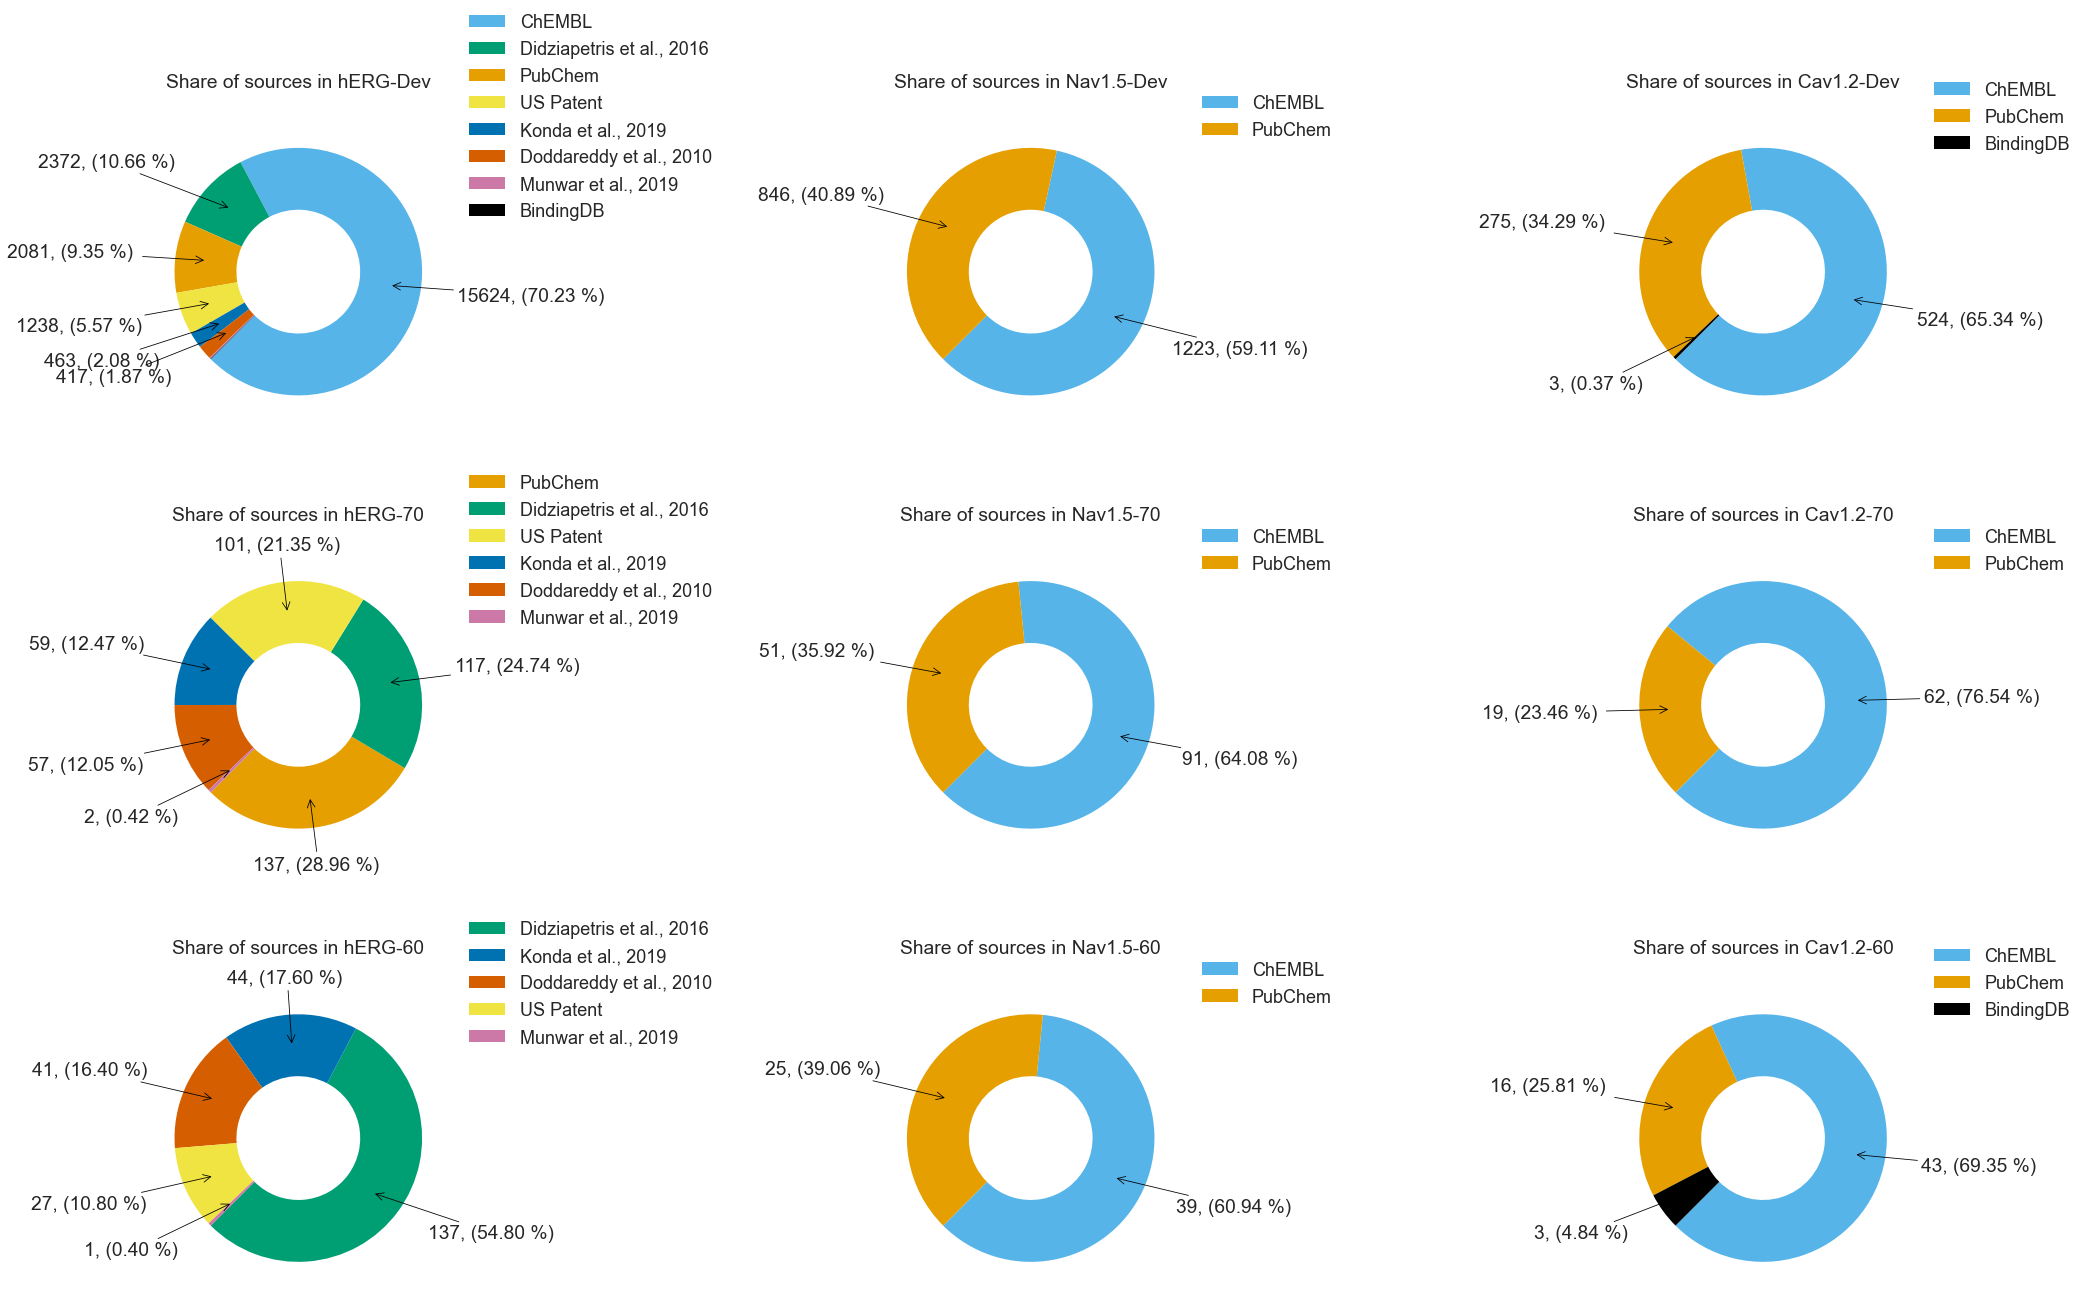

In [9]:

## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=2.0)    # Single-column figure.
width = 35
height = width / 1.618
fig,aks = plt.subplots(3,3,figsize=(width, height))

#Generating Sources pie chart
#fig,aks = plt.subplots(3,3,figsize=(30, 20))
targets =["hERG","Nav1.5","Cav1.2"]
sets=["-Dev","-70","-60"]
colors={}
list_of_colors=["#56B4E9", "#009E73", "#E69F00", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

def plot_source_pie(data,aks,title):
    frequency = Counter(list(data.Source))
    labels = []
    sizes = []
    annotations=[]
    color_for_pie=[]
    for x, y in frequency.most_common():
        #print(x)
        sizes.append(y)
        labels.append("{}".format(x))
        if x not in colors:
            colors[x]=list_of_colors.pop(0)
        color_for_pie.append(colors[x])
        
    for size in sizes:
        annotations.append("{}, ({:.2f} %) ".format(size, 100*size/sum(sizes)))
    # Plot
    wedges,teksts=aks.pie(sizes,colors=color_for_pie,wedgeprops=dict(width=0.5), startangle=225)
    kw = dict(arrowprops=dict(arrowstyle="->"), va="center")
    
    #generate wedges, if its less than 0.2 percent, dont show the annotation
    for p, label in zip(wedges, annotations):
        amount=float(label.strip().replace('(','').replace(')','').split(',')[-1][:-1])
        if amount < 0.2:
            continue
        ang = np.deg2rad((p.theta1 + p.theta2)/2)
        y = np.sin(ang)
        x = np.cos(ang)
        horizontalalignment = "center" if abs(x) < abs(y) else "right" if x < 0 else "left"
        aks.annotate(label, xy=(0.75*x, 0.75*y), xytext=(1.3*x, 1.3*y), horizontalalignment=horizontalalignment, **kw)

    #all labels are shown however
    aks.legend(labels,loc='center left' ,bbox_to_anchor=(1,1.0),
           fontsize=18)
    aks.set_title(title, pad=30.0)
    
for ind,source in enumerate([datasets_dev,datasets_70,datasets_60]):
    for ind2, data in enumerate(source):
        #print(ind)
        plot_source_pie(data,aks[ind][ind2],"Share of sources in {}{}".format(targets[ind2],sets[ind]))

# Add space between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.4)
#plt.savefig('upstream_datasources_perset_shares.png', dpi=600, bbox_inches='tight')
plt.show()

### Physicochemical properties

#### Compute properties

In [10]:
for data in [data_herg,data_nav,data_cav]:
    data["MOL"]=data["SMILES"].agg(Chem.MolFromSmiles)
    data["prop"]=data["MOL"].agg(properties)

In [11]:
def split_list_to_columns(row):
    values = list(row['prop'])
    new_columns = pd.Series(values)
    new_columns = new_columns.rename({0: 'MW', 1: 'AlogP', 2: 'HBA', 3: 'HBD', 4: 'MPSA', 5: 'ROTB', 6: 'AROMS', 7: 'ALERTS'})
    return new_columns

In [12]:
# hERG
properties = data_herg.apply(split_list_to_columns, axis=1)
data_herg = pd.concat([data_herg, properties], axis=1)
# Nav1.5
properties = data_nav.apply(split_list_to_columns, axis=1)
data_nav = pd.concat([data_nav, properties], axis=1)
# Cav1.2
properties = data_cav.apply(split_list_to_columns, axis=1)
data_cav = pd.concat([data_cav, properties], axis=1)

In [13]:
## Statisitcs hERG
df = data_herg[data_herg['pIC50'] >= 5][['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']]
herg_blockers_statistics = {'mean': df.mean().to_dict(), 'std': df.std().to_dict()}
df = data_herg[data_herg['pIC50'] < 5][['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']]
herg_nonblocker_statistics = {'mean': df.mean().to_dict(), 'std': df.std().to_dict()}
## Statisitcs Nav
df = data_nav[data_nav['pIC50'] >= 5][['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']]
nav_blockers_statistics = {'mean': df.mean().to_dict(), 'std': df.std().to_dict()}
df = data_nav[data_nav['pIC50'] < 5][['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']]
nav_nonblocker_statistics = {'mean': df.mean().to_dict(), 'std': df.std().to_dict()}
## Statisitcs Cav
df = data_cav[data_cav['pIC50'] >= 5][['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']]
cav_blockers_statistics = {'mean': df.mean().to_dict(), 'std': df.std().to_dict()}
df = data_cav[data_cav['pIC50'] < 5][['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']]
cav_nonblocker_statistics = {'mean': df.mean().to_dict(), 'std': df.std().to_dict()}

### Visualize properties

#### Independent and Identically Distributed Analysis

In [14]:
def plot_subplots(df):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.3)    # Single-column figure.
    width = 14
    height = width / 1.618
    columns = ['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']
    #categories = ["inhibitor", "inactive"]
    categories = ["Dev-Set", "Eval-Set"]
    fig, axes = plt.subplots(2,4,figsize=(width, height))

    for i, ax in enumerate(axes.flat):
        column = columns[i]
        for category in categories:
            sns.kdeplot(list(df[df['label'] == category][column]), ax=ax, label=category)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        if column == 'AlogP':
            ax.legend(loc='upper left')
        else:
            ax.legend()

    plt.tight_layout()
    plt.show()

##### hERG

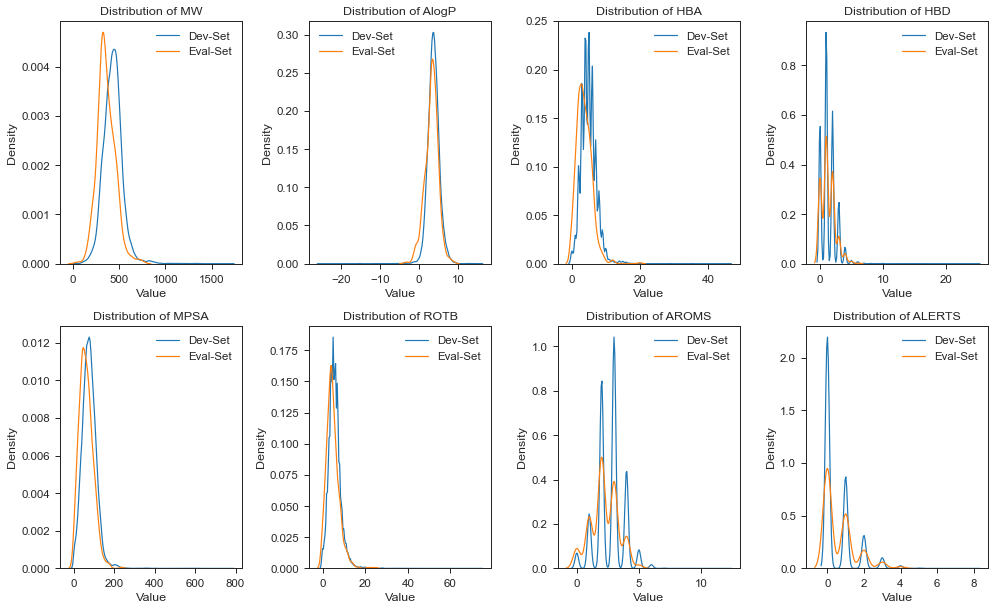

In [15]:
data_herg['USED_AS_Bit'] = data_herg.apply(lambda x: 1 if x['USED_AS'] == 'Dev-Set' else 0 , axis = 1)
data_herg['label'] = np.where(data_herg['USED_AS_Bit'] == 1, 'Dev-Set', 'Eval-Set')
plot_subplots(data_herg)

In [16]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding = tsne_model.fit_transform(data_herg_fingerprints)

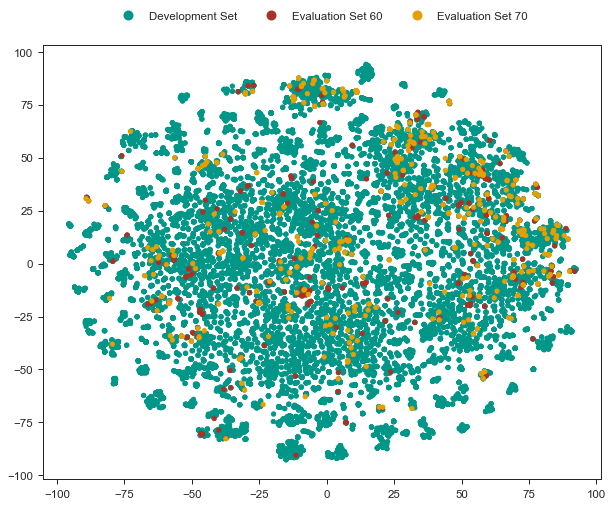

In [17]:
label_mapping = {'Dev-Set': ('Development Set', '#009688'), 'Eval-Set-60': ('Evaluation Set 60', '#A93226'), 'Eval-Set-70': ('Evaluation Set 70', '#E69F00')}
data_herg['USED_AS'], colors = zip(*data_herg['USED_AS'].map(label_mapping))

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=colors, s=20, cmap='cividis')

legend_labels, legend_colors = zip(*label_mapping.values())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='', loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.show()

##### Nav1.5

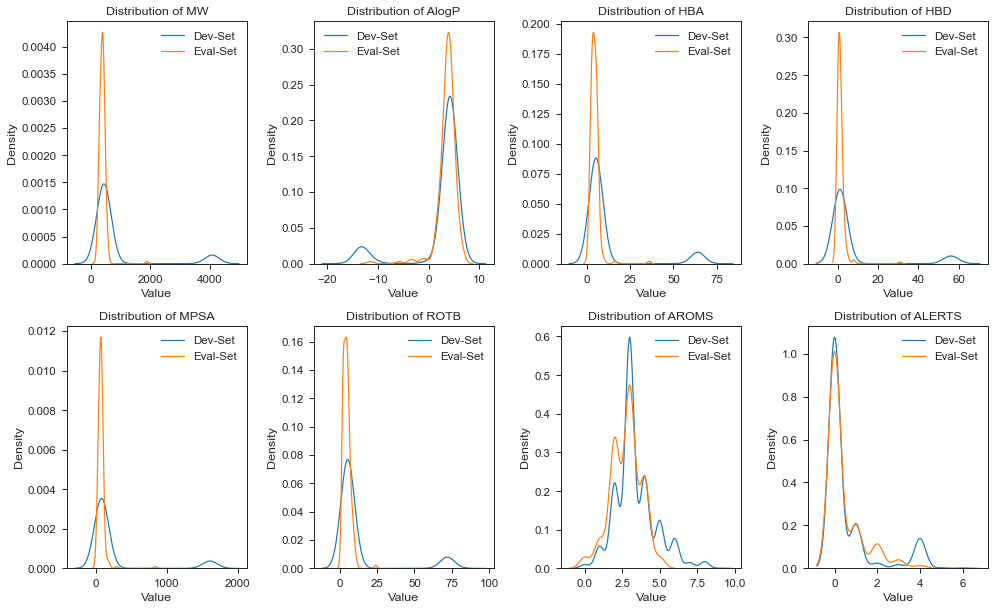

In [18]:
data_nav['USED_AS_Bit'] = data_nav.apply(lambda x: 1 if x['USED_AS'] == 'Dev-Set' else 0 , axis = 1)
data_nav['label'] = np.where(data_nav['USED_AS_Bit'] == 1, 'Dev-Set', 'Eval-Set')
plot_subplots(data_nav)

In [19]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding = tsne_model.fit_transform(data_nav_fingerprints)

In [ ]:
len(tsne_embedding[:, 1])

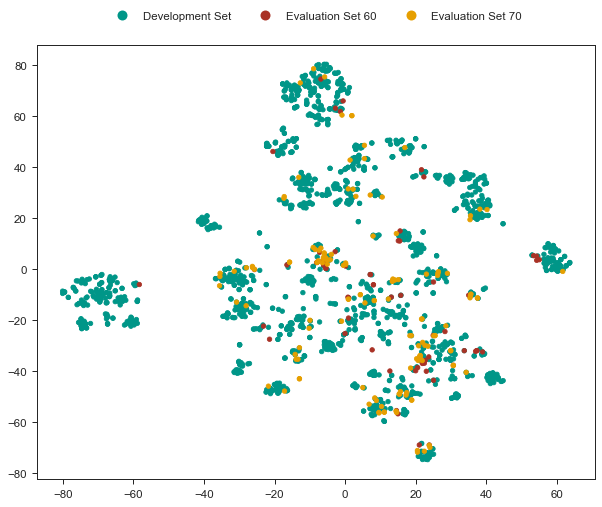

In [20]:
label_mapping = {'Dev-Set': ('Development Set', '#009688'), 'Eval-Set-60': ('Evaluation Set 60', '#A93226'), 'Eval-Set-70': ('Evaluation Set 70', '#E69F00')}
data_nav['USED_AS'], colors = zip(*data_nav['USED_AS'].map(label_mapping))

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=colors, s=20, cmap='cividis')
legend_labels, legend_colors = zip(*label_mapping.values())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='', loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.show()

##### Cav1.2

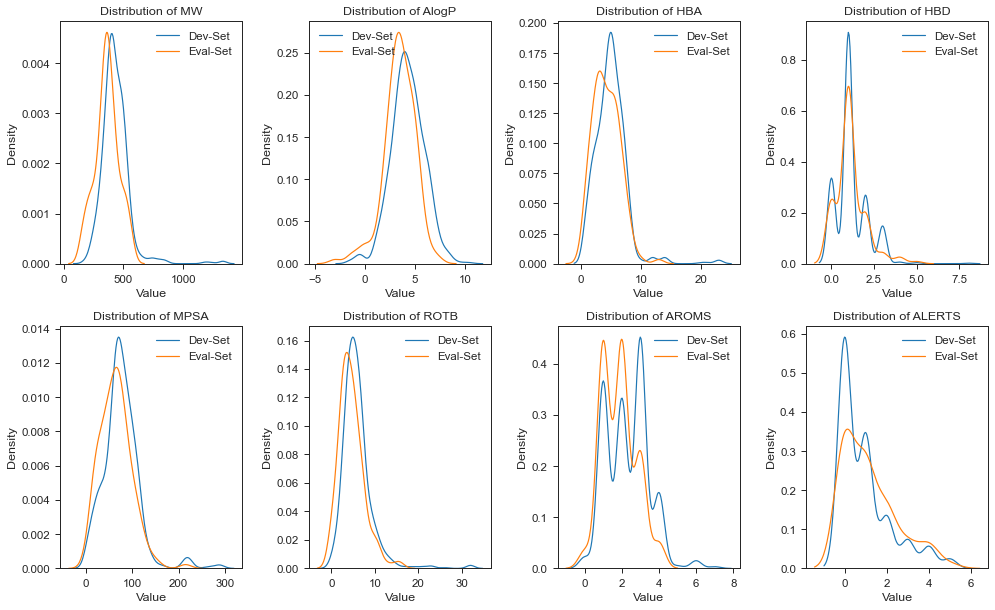

In [21]:
data_cav['USED_AS_Bit'] = data_cav.apply(lambda x: 1 if x['USED_AS'] == 'Dev-Set' else 0 , axis = 1)
data_cav['label'] = np.where(data_cav['USED_AS_Bit'] == 1, 'Dev-Set', 'Eval-Set')
plot_subplots(data_cav)

In [22]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding = tsne_model.fit_transform(data_cav_fingerprints)

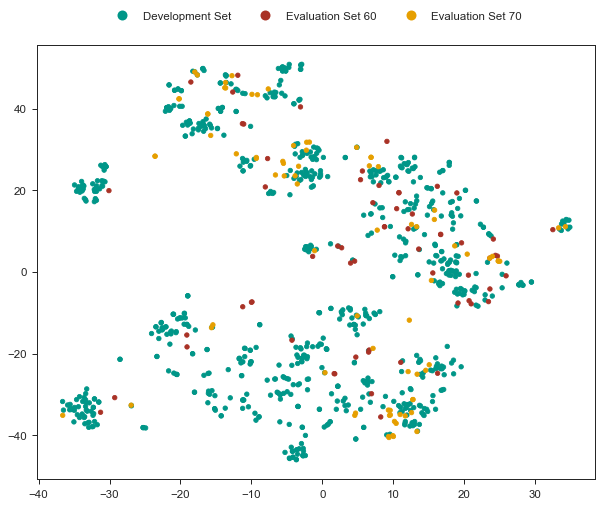

In [23]:
label_mapping = {'Dev-Set': ('Development Set', '#009688'), 'Eval-Set-60': ('Evaluation Set 60', '#A93226'), 'Eval-Set-70': ('Evaluation Set 70', '#E69F00')}
data_cav['USED_AS'], colors = zip(*data_cav['USED_AS'].map(label_mapping))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=colors, s=20, cmap='cividis')
legend_labels, legend_colors = zip(*label_mapping.values())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
                  for label, color in zip(legend_labels, legend_colors)]

plt.legend(handles=legend_handles, title='', loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.show()

#### Inhibitors vs Inactives Analysis 

In [24]:
def plot_subplots(df):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.3)    # Single-column figure.
    width = 14
    height = width / 1.618
    columns = ['MW', 'AlogP', 'HBA', 'HBD', 'MPSA', 'ROTB', 'AROMS', 'ALERTS']
    categories = ["inhibitor", "inactive"]
    fig, axes = plt.subplots(2,4,figsize=(width, height))

    for i, ax in enumerate(axes.flat):
        column = columns[i]
        for category in categories:
            sns.kdeplot(list(df[df['label'] == category][column]), ax=ax, label=category)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        if column == 'AlogP':
            ax.legend(loc='upper left')
        else:
            ax.legend()

    plt.tight_layout()
    plt.show()

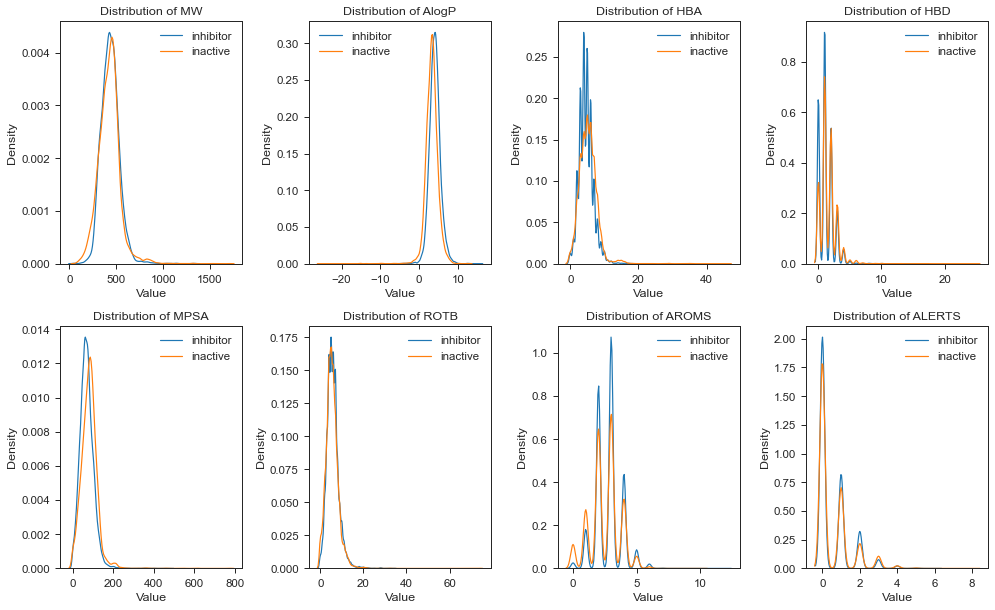

In [25]:
## hERG
data_herg['label'] = np.where(data_herg['pIC50'] >= 5, 'inhibitor', 'inactive')
plot_subplots(data_herg)

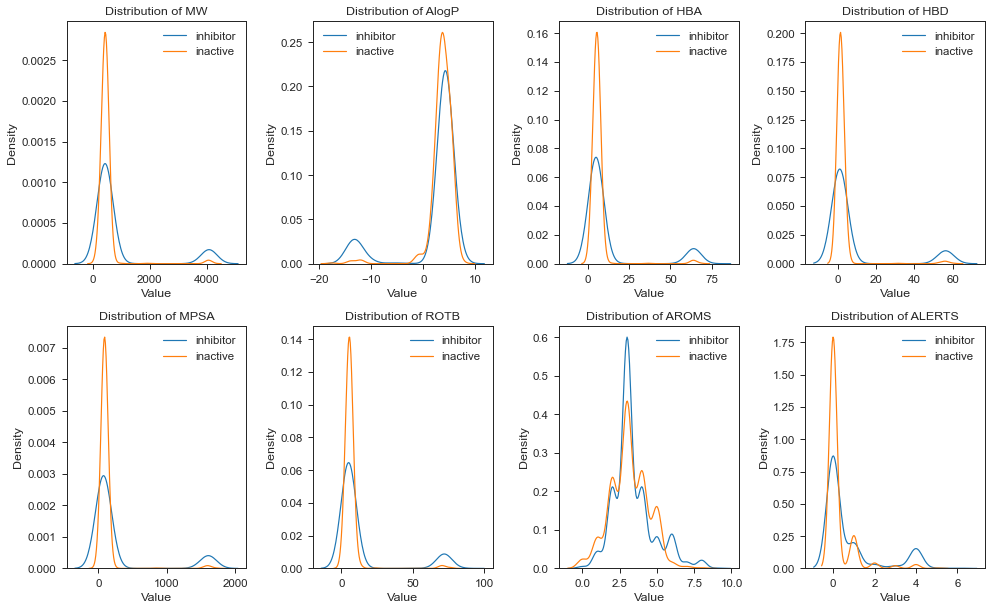

In [26]:
## Nav1.5
data_nav['label'] = np.where(data_nav['pIC50'] >= 5, 'inhibitor', 'inactive')
plot_subplots(data_nav)

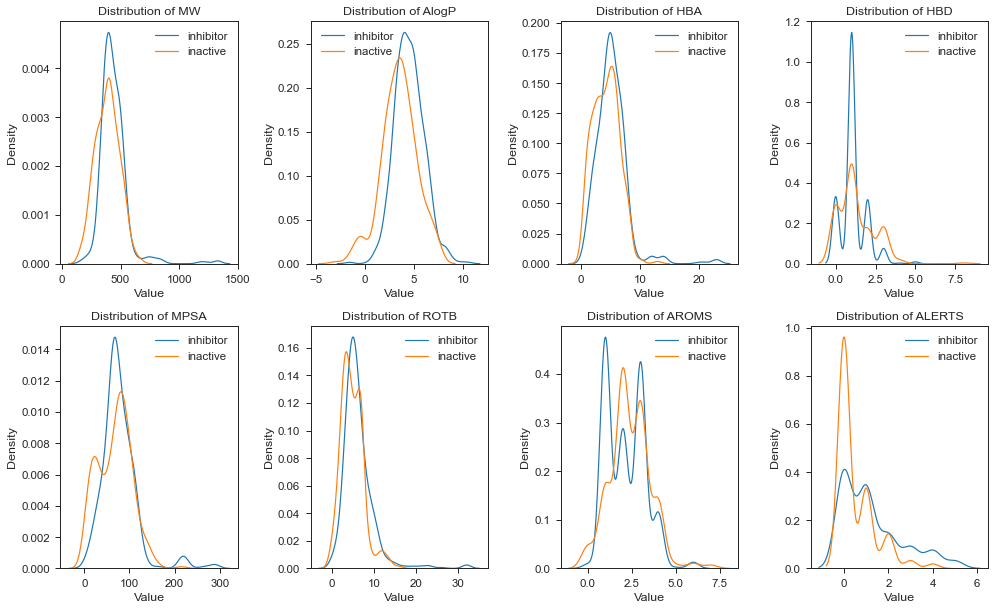

In [27]:
## Cav1.2
data_cav['label'] = np.where(data_cav['pIC50'] >= 5, 'inhibitor', 'inactive')
plot_subplots(data_cav)

### Atoms distribution

#### hERG

In [28]:
atom_size_per_molecule = []
all_atoms = []

for smiles in data_herg['SMILES']:
    smiles_Mol = Chem.MolFromSmiles(smiles.strip())
    smiles_AdjTmp = Chem.rdmolops.GetAdjacencyMatrix(smiles_Mol)
    atom_size_per_molecule.append(smiles_AdjTmp.shape[0])
    all_atoms.extend([atom.GetSymbol() for atom in smiles_Mol.GetAtoms()])

In [29]:
count_dic = Counter(all_atoms)
values_dic = {key: value for (key, value) in count_dic.items()}

In [30]:
color_map = {
    'As': '#000000',
    'B': '#FF0000',
    'Bi': '#00FF00',
    'Br': '#0000FF',
    'C': '#0000FF',
    'Ca': '#FF00FF',
    'Cd': '#00FFFF',
    'Cl': '#800080',
    'Cr': '#008000',
    'Cu': '#000080',
    'F': '#FF0000',
    'Fe': '#800080',
    'H': '#008080',
    'Hg': '#808080',
    'I': '#C0C0C0',
    'In': '#FF8080',
    'K': '#FFCC00',
    'Li': '#CCFF00',
    'N': '#FFA500',
    'Na': '#00CCFF',
    'O': '#008000',
    'P': '#FF00FF',
    'Pb': '#FF9933',
    'S': '#FFFF00',
    'Sb': '#CCFF99',
    'Se': '#FFFF00',
    'Si': '#800080',
    'Sn': '#FF99CC',
    'Zn': '#990000',
}

In [31]:
def plot_histogram_with_colors_and_categories(data_dict, color_dict, category_dict):
    keys = list(data_dict.keys())
    values = list(data_dict.values())
    total = sum(values)
    percentages = [value / total * 100 for value in values]

    categories = list(color_dict.keys())
    colors = list(color_dict.values())

    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.5)

    width = 10
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))

    bars = ax.bar(keys, percentages)
    

    for i in range(len(keys)):
        category = keys[i]
        color = colors[categories.index(category)]
        bar = bars[i]
        bar.set_color(color)

    ax.set_xlabel('Atoms')
    ax.set_ylabel('Percentage(%)')
    ax.set_ylim(0, 80)
    plt.xticks(rotation=-90)
    plt.show()

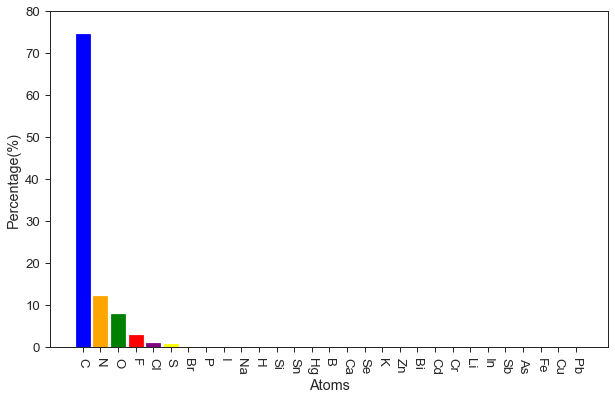

In [32]:
data =  dict(sorted(values_dic.items(), key=lambda item: item[1], reverse=True))
colors = color_map
categories = color_map
plot_histogram_with_colors_and_categories(data, colors, categories)

In [33]:
## Plot number of atoms per molecule distribution
_number_of_atoms = sorted(atom_size_per_molecule)
_number_of_atoms = [str(x) for x in _number_of_atoms]
_num_of_atoms_dist = {key: value for (key, value) in Counter(_number_of_atoms).items()}

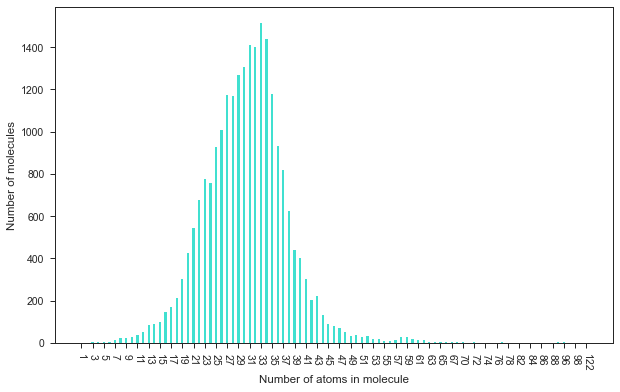

In [34]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.2)

width = 10
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

# Plotting the distribution
ax.bar(_num_of_atoms_dist.keys(), _num_of_atoms_dist.values(), color='#40E0D0',width=0.4)
ax.set_xlabel('Number of atoms in molecule')
ax.set_ylabel('Number of molecules')

# Display the plot
plt.xticks(rotation=-90)

# Hide even x-axis values
# for nice visualization
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])

plt.show()

#### Nav1.5

In [35]:
atom_size_per_molecule = []
all_atoms = []

for smiles in data_nav['SMILES']:
    smiles_Mol = Chem.MolFromSmiles(smiles.strip())
    smiles_AdjTmp = Chem.rdmolops.GetAdjacencyMatrix(smiles_Mol)
    atom_size_per_molecule.append(smiles_AdjTmp.shape[0])
    all_atoms.extend([atom.GetSymbol() for atom in smiles_Mol.GetAtoms()])

In [36]:
count_dic = Counter(all_atoms)
values_dic = {key: value for (key, value) in count_dic.items()}

In [37]:
color_map = {
    'As': '#000000',
    'B': '#FF0000',
    'Bi': '#00FF00',
    'Br': '#0000FF',
    'C': '#0000FF',
    'Ca': '#FF00FF',
    'Cd': '#00FFFF',
    'Cl': '#800080',
    'Cr': '#008000',
    'Cu': '#000080',
    'F': '#FF0000',
    'Fe': '#800080',
    'H': '#008080',
    'Hg': '#808080',
    'I': '#C0C0C0',
    'In': '#FF8080',
    'K': '#FFCC00',
    'Li': '#CCFF00',
    'N': '#FFA500',
    'Na': '#00CCFF',
    'O': '#008000',
    'P': '#FF00FF',
    'Pb': '#FF9933',
    'S': '#FFFF00',
    'Sb': '#CCFF99',
    'Se': '#FFFF00',
    'Si': '#800080',
    'Sn': '#FF99CC',
    'Zn': '#990000',
}

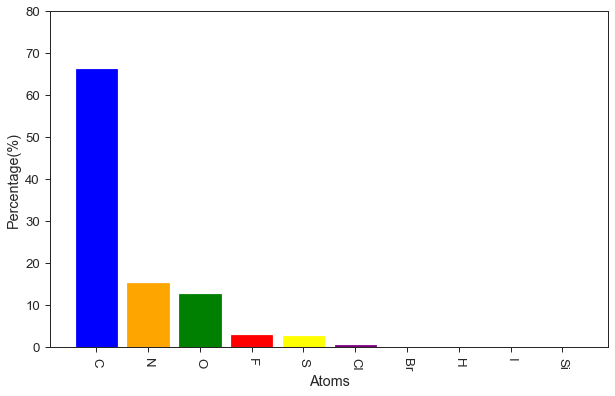

In [38]:
data =  dict(sorted(values_dic.items(), key=lambda item: item[1], reverse=True))
colors = color_map
categories = color_map
plot_histogram_with_colors_and_categories(data, colors, categories)

In [39]:
## Plot number of atoms per molecule distribution
_number_of_atoms = sorted(atom_size_per_molecule)
_number_of_atoms = [str(x) for x in _number_of_atoms]
_num_of_atoms_dist = {key: value for (key, value) in Counter(_number_of_atoms).items()}

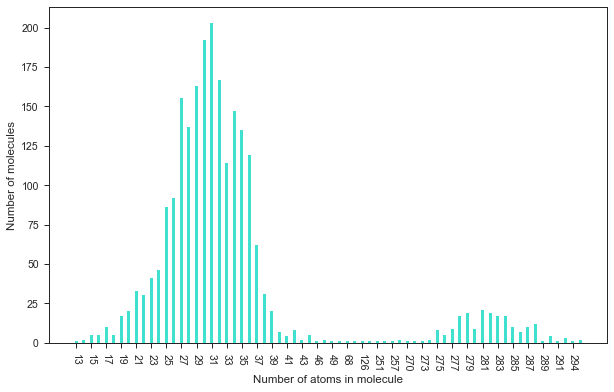

In [40]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.2)

width = 10
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

# Plotting the distribution
ax.bar(_num_of_atoms_dist.keys(), _num_of_atoms_dist.values(), color='#40E0D0',width=0.4)
ax.set_xlabel('Number of atoms in molecule')
ax.set_ylabel('Number of molecules')

# Display the plot
plt.xticks(rotation=-90)

# Hide even x-axis values
# for nice visualization
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])

plt.show()

#### Cav1.5

In [41]:
atom_size_per_molecule = []
all_atoms = []

for smiles in data_cav['SMILES']:
    smiles_Mol = Chem.MolFromSmiles(smiles.strip())
    smiles_AdjTmp = Chem.rdmolops.GetAdjacencyMatrix(smiles_Mol)
    atom_size_per_molecule.append(smiles_AdjTmp.shape[0])
    all_atoms.extend([atom.GetSymbol() for atom in smiles_Mol.GetAtoms()])

In [42]:
count_dic = Counter(all_atoms)
values_dic = {key: value for (key, value) in count_dic.items()}

In [43]:
color_map = {
    'As': '#000000',
    'B': '#FF0000',
    'Bi': '#00FF00',
    'Br': '#0000FF',
    'C': '#0000FF',
    'Ca': '#FF00FF',
    'Cd': '#00FFFF',
    'Cl': '#800080',
    'Cr': '#008000',
    'Cu': '#000080',
    'F': '#FF0000',
    'Fe': '#800080',
    'H': '#008080',
    'Hg': '#808080',
    'I': '#C0C0C0',
    'In': '#FF8080',
    'K': '#FFCC00',
    'Li': '#CCFF00',
    'N': '#FFA500',
    'Na': '#00CCFF',
    'O': '#008000',
    'P': '#FF00FF',
    'Pb': '#FF9933',
    'S': '#FFFF00',
    'Sb': '#CCFF99',
    'Se': '#FFFF00',
    'Si': '#800080',
    'Sn': '#FF99CC',
    'Zn': '#990000',
}

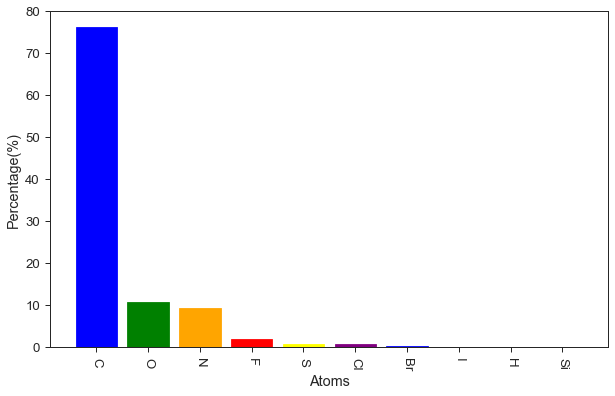

In [44]:
data =  dict(sorted(values_dic.items(), key=lambda item: item[1], reverse=True))
colors = color_map
categories = color_map
plot_histogram_with_colors_and_categories(data, colors, categories)

In [45]:
## Plot number of atoms per molecule distribution
_number_of_atoms = sorted(atom_size_per_molecule)
_number_of_atoms = [str(x) for x in _number_of_atoms]
_num_of_atoms_dist = {key: value for (key, value) in Counter(_number_of_atoms).items()}

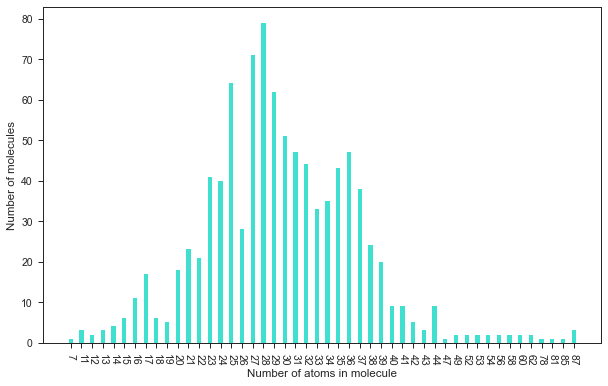

In [46]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.2)

width = 10
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

# Plotting the distribution
ax.bar(_num_of_atoms_dist.keys(), _num_of_atoms_dist.values(), color='#40E0D0',width=0.4)
ax.set_xlabel('Number of atoms in molecule')
ax.set_ylabel('Number of molecules')

# Display the plot
plt.xticks(rotation=-90)

# Hide even x-axis values
# for nice visualization
#xticks = ax.get_xticks()
#ax.set_xticks(xticks[::2])

plt.show()

### Models performance

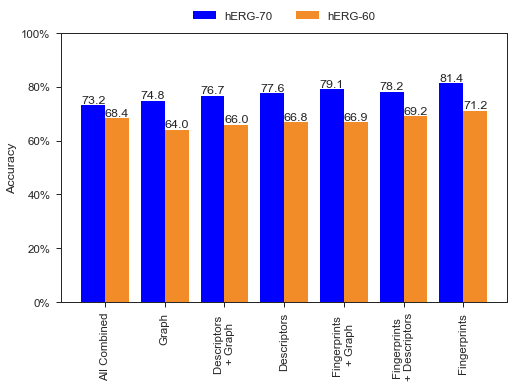

In [47]:
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(x[i], y[i], y[i], ha='center', va='bottom')

# Plotting config.
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.3)

width = 8
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

methods = ['All Combined', 'Graph', 'Descriptors \n+ Graph', 'Descriptors', 'Fingerprints \n+ Graph' , 'Fingerprints \n+ Descriptors', 'Fingerprints']
values1 = [73.2, 74.8, 76.7, 77.6, 79.1, 78.2, 81.4]  
values2 = [68.4, 64.0, 66.0, 66.8, 66.9, 69.2, 71.2]  

index = np.arange(len(methods))
bar_width = 0.40

ax.set_ylabel('Accuracy')
ax.bar(index - bar_width/2, values1, bar_width, color='b', hatch='', label='hERG-70')
ax.bar(index + bar_width/2, values2, bar_width, color='#F28C28', hatch='', label='hERG-60')

addlabels(index - bar_width/2, values1)
addlabels(index + bar_width/2, values2)

plt.xticks(index, methods)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None, symbol='%', is_latex=False))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 100])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
plt.show()
#plt.savefig('hERG_Models_Performance.png', dpi=400, bbox_inches='tight')

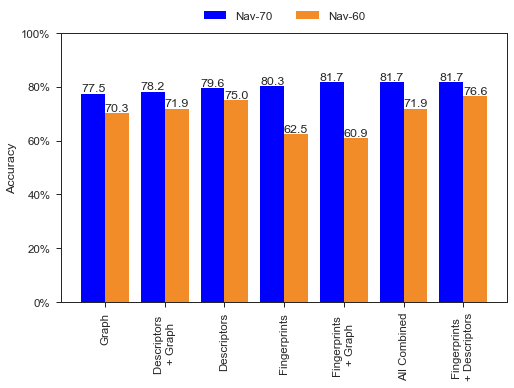

In [48]:
fig, ax = plt.subplots(figsize=(width, height))

methods = ['Graph',  'Descriptors \n+ Graph', 'Descriptors', 'Fingerprints', 'Fingerprints \n+ Graph', 'All Combined', 'Fingerprints \n+ Descriptors']
values1 = [77.5, 78.2, 79.6, 80.3, 81.7, 81.7, 81.7]
values2 = [70.3, 71.9, 75.0, 62.5, 60.9, 71.9, 76.6]

index = np.arange(len(methods))
bar_width = 0.40

ax.set_ylabel('Accuracy')
ax.bar(index - bar_width/2, values1, bar_width, color='b', hatch='', label='Nav-70')
ax.bar(index + bar_width/2, values2, bar_width, color='#F28C28', hatch='', label='Nav-60')

addlabels(index - bar_width/2, values1)
addlabels(index + bar_width/2, values2)

plt.xticks(index, methods)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None, symbol='%', is_latex=False))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 100])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
plt.show()
#plt.savefig('Nav1.5_Models_Performance.png', dpi=400, bbox_inches='tight')

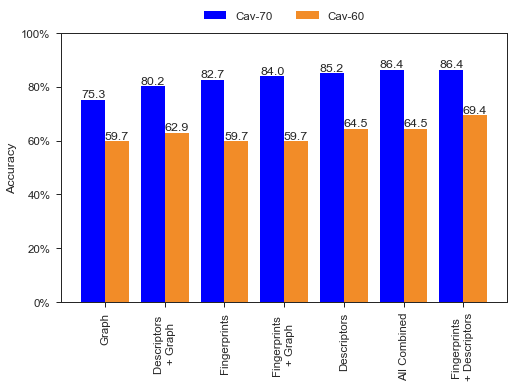

In [49]:
fig, ax = plt.subplots(figsize=(width, height))

methods = ['Graph', 'Descriptors \n+ Graph', 'Fingerprints', 'Fingerprints \n+ Graph',  'Descriptors', 'All Combined', 'Fingerprints \n+ Descriptors']
values1 = [75.3, 80.2, 82.7, 84.0, 85.2, 86.4, 86.4]
values2 = [59.7, 62.9, 59.7, 59.7, 64.5, 64.5, 69.4]

index = np.arange(len(methods))
bar_width = 0.40

ax.set_ylabel('Accuracy')
ax.bar(index - bar_width/2, values1, bar_width, color='b', hatch='', label='Cav-70')
ax.bar(index + bar_width/2, values2, bar_width, color='#F28C28', hatch='', label='Cav-60')

addlabels(index - bar_width/2, values1)
addlabels(index + bar_width/2, values2)

plt.xticks(index, methods)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None, symbol='%', is_latex=False))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 100])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
plt.show()
#plt.savefig('Cav1.2_Models_Performance.png', dpi=400, bbox_inches='tight')